# Imports

In [2]:
# Tells matplotlib to display images inline instead of a new window
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm

We'll start by importing the data from Boston.csv into a pandas dataframe:

In [105]:
df = pd.read_csv('Boston.csv', index_col=0)
df.head()

crim  zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
1  0.00632  18   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
2  0.02731   0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
3  0.02729   0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
4  0.03237   0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
5  0.06905   0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
1  396.90   4.98  24.0  
2  396.90   9.14  21.6  
3  392.83   4.03  34.7  
4  394.63   2.94  33.4  
5  396.90   5.33  36.2

# Simple Linear Regression

Now let's fit a simple linear model (OLS - for "ordinary least squares" method) with ${\tt medv}$ as the response and ${\tt lstat}$ as the predictor:

In [106]:
lm = sm.OLS.from_formula('medv ~ lstat', df)
result = lm.fit()

To get detailed information about the model, we can print the results of a call to the ${\tt .summary()}$ method:

In [107]:
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Wed, 03 Feb 2016   Prob (F-statistic):           5.08e-88
Time:                        21:36:56   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

Want individual attributes? You can access them independently like this:

In [108]:
result.rsquared, result.fvalue, result.params.Intercept, result.params.lstat

(0.5441462975864797,
 601.6178711098953,
 34.553840879383074,
 -0.9500493537579906)

For a complete list of attributes and methods of a ${\tt RegressionResults}$ object, see: http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.RegressionResults.html?highlight=regressionresults

Now let's try making some predictions using this model. First, we'll set up a dataframe containing the ${\tt lstat}$ values for which we want to predict a response:

In [109]:
new = pd.DataFrame([[1, 5], [1, 10], [1, 15]], columns=['Intercept', 'lstat'])

Now we just call the ${\tt .predict()}$ method:

In [110]:
result.predict(new)

array([ 29.80359411,  25.05334734,  20.30310057])

Technically those are the right prediction values, but maybe it would be good to have the confidence intervals along with them. Let's write a little helper function to get that and package it all up:

In [111]:
def predict(res, new):
    
    # Get the predicted values
    fit = pd.DataFrame(res.predict(new), columns=['fit'])
    
    # Get the confidence interval for the model (and rename the columns to something a bit more useful)
    ci = res.conf_int().rename(columns={0: 'lower', 1: 'upper'})
    
    # Now a little bit of matrix multiplication to get the confidence intervals for the predictions
    ci = ci.T.dot(new.T).T
    
    # And finally wrap up the confidence intervals with the predicted values
    return pd.concat([fit, ci], axis=1)

In [112]:
predict(result, new)

fit      lower      upper
0  29.803594  28.317716  31.289472
1  25.053347  23.186975  26.919720
2  20.303101  18.056234  22.549967

Seaborn is a Python visualization library based on matplotlib that provides a high-level interface for drawing attractive statistical graphics.

In [113]:
import seaborn as sns

We will now plot ${\tt medv}$ and ${\tt lstat}$ along with the least squares regression line using the ${\tt regplot()}$ function. We can define the color of the fit line using ${\tt line\_kws}$ ("line keywords"):

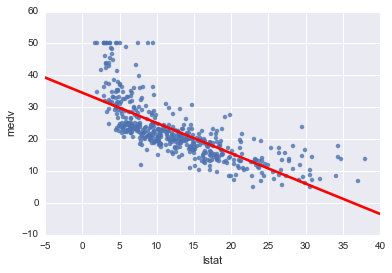

In [114]:
sns.regplot('lstat', 'medv', df, line_kws = {"color":"r"}, ci=None)

We can also plot the residuals against the fitted values:

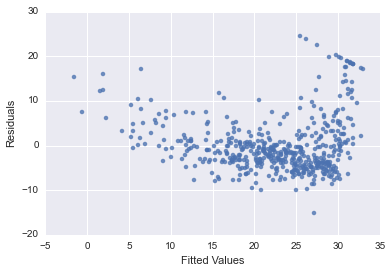

In [115]:
fitted_values = pd.Series(result.fittedvalues, name="Fitted Values")
residuals = pd.Series(result.resid, name="Residuals")
sns.regplot(fitted_values, residuals, fit_reg=False)

Perhaps we want normalized residuals instead?

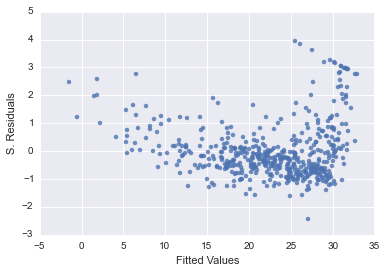

In [116]:
s_residuals = pd.Series(result.resid_pearson, name="S. Residuals")
sns.regplot(fitted_values, s_residuals,  fit_reg=False)

We can also look for points with high leverage:

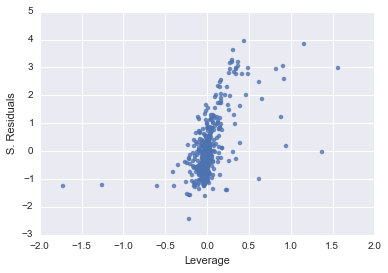

In [130]:
from statsmodels.stats.outliers_influence import OLSInfluence
leverage = pd.Series(OLSInfluence(result).influence, name = "Leverage")
sns.regplot(leverage, s_residuals,  fit_reg=False)

# Multiple Linear Regression

In order to fit a multiple linear regression model using least squares, we again use the ${\tt from\_formula()}$ function. The syntax ${\tt from\_formula(y∼x1+x2+x3)}$ is used to fit a model with three predictors, $x1$, $x2$, and $x3$. The ${\tt summary()}$ function now outputs the regression coefficients for all the predictors.

In [131]:
model = sm.OLS.from_formula('medv ~ lstat + age', df)
result = model.fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Wed, 03 Feb 2016   Prob (F-statistic):           2.98e-88
Time:                        21:38:14   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     33.2228      0.731     45.458      0.0

The Boston data set contains 13 variables, and so it would be cumbersome to have to type all of these in order to perform a regression using all of the predictors. Instead, we can use the following short-hand:

In [132]:
# All columns (except medv, which is our response)
model = sm.OLS.from_formula('medv ~ ' + '+'.join(df.columns.difference(['medv'])), df)
result = model.fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Wed, 03 Feb 2016   Prob (F-statistic):          6.72e-135
Time:                        21:38:15   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.0

Note that we used the syntax ${\tt .join(df.columns.difference(['medv']))}$ to exclude the response variable above. We can use the same napproach to perform a regression using just a subset of the predictors? For example, in the above regression output, ${\tt age}$ and ${\tt indus}$ have a high p-value. So we may wish to run a regression excluding these predictors:

In [133]:
# All columns (except medv)
model = sm.OLS.from_formula('medv ~ ' + '+'.join(df.columns.difference(['medv', 'age', 'indus'])), df)
result = model.fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     128.2
Date:                Wed, 03 Feb 2016   Prob (F-statistic):          5.54e-137
Time:                        21:38:18   Log-Likelihood:                -1498.9
No. Observations:                 506   AIC:                             3022.
Df Residuals:                     494   BIC:                             3072.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     36.3411      5.067      7.171      0.0

# Interaction Terms

It is easy to include interaction terms in a linear model using the ${\tt .from\_formula()}$ function. The syntax ${\tt lstat:black}$ tells Python to include an interaction term between ${\tt lstat}$ and ${\tt black}$. The syntax ${\tt lstat*age}$ simultaneously includes ${\tt lstat}$, ${\tt age}$, and the interaction term ${\tt lstat×age}$ as predictors; it is a shorthand for ${\tt lstat+age+lstat:age}$.

In [134]:
print sm.OLS.from_formula('medv ~ lstat*age', df).fit().summary()

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Wed, 03 Feb 2016   Prob (F-statistic):           4.86e-88
Time:                        21:38:20   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     36.0885      1.470     24.553      0.0

# Non-linear Transformations of the Predictors

The ${\tt .from\_formula()}$ function can also accommodate non-linear transformations of the predictors. For instance, given a predictor ${\tt X}$, we can create a predictor ${\tt X^\wedge2}$ using ${\tt np.square(X)}$. We now perform a regression of ${\tt medv}$ onto ${\tt lstat}$ and ${\tt lstat^\wedge 2}$.

In [135]:
lm.fit2 = sm.OLS.from_formula('medv ~ lstat + np.square(lstat)', df).fit()
print lm.fit2.summary()

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Wed, 03 Feb 2016   Prob (F-statistic):          1.56e-112
Time:                        21:38:23   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           42.8620      0.872  

The near-zero p-value associated with the quadratic term suggests that it leads to an improved model. We use the ${\tt anova\_lm()}$ function to further quantify the extent to which the quadratic fit is superior to the linear fit.

In [136]:
lm.fit = sm.OLS.from_formula('medv ~ lstat', df).fit()
print sm.stats.anova_lm(lm.fit, lm.fit2)

   df_resid           ssr  df_diff     ss_diff           F        Pr(>F)
0       504  19472.381418        0         NaN         NaN           NaN
1       503  15347.243158        1  4125.13826  135.199822  7.630116e-28


Here Model 0 represents the linear submodel containing only one predictor, ${\tt lstat}$, while Model 1 corresponds to the larger quadraticmodel that has two predictors, ${\tt lstat}$ and ${\tt lstat2}$. The ${\tt anova\_lm()}$ function performs a hypothesis test comparing the two models. The null hypothesis is that the two models fit the data equally well, and the alternative hypothesis is that the full model is superior. 

The F-statistic is 135 and the associated p-value is virtually zero. This provides very clear evidence that the model containing the predictors ${\tt lstat}$ and ${\tt lstat2}$ is far superior to the model that only contains the predictor ${\tt lstat}$. This is not surprising, since earlier we saw evidence for non-linearity in the relationship between ${\tt medv}$ and ${\tt lstat}$. 

If we type:

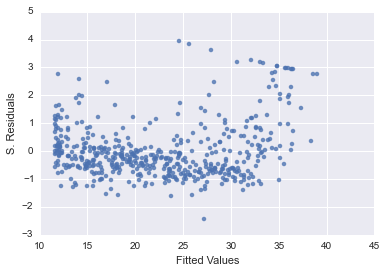

In [137]:
fitted_values = pd.Series(lm.fit2.fittedvalues, name="Fitted Values")
residuals = pd.Series(lm.fit2.resid, name="S. Residuals")
sns.regplot(fitted_values, s_residuals,  fit_reg=False)

then we see that when the ${\tt lstat2}$ term is included in the model, there is little discernible pattern in the residuals.

In order to create a cubic fit, we can include a predictor of the form ${\tt np.power(x, 3))}$. However, this approach can start to get cumbersome for higher order polynomials. A better approach involves using list comprehension inside a ${\tt .join()}$. For example, the following command produces a fifth-order polynomial fit:

In [138]:
sm.OLS.from_formula('medv ~ ' + '+'.join(['np.power(lstat,' + str(i) + ')' for i in range(1,6)]), df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     214.2
Date:                Wed, 03 Feb 2016   Prob (F-statistic):          8.73e-122
Time:                        21:38:31   Log-Likelihood:                -1550.6
No. Observations:                 506   AIC:                             3113.
Df Residuals:                     500   BIC:                             3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             67.6997      3.604     18.783      0.000        60.618    74.781
np.power(lstat, 1)   -11.9911      1.526     -7.859      0.000       -14.989    -8.994
np.power(lstat, 2)     1.2728      0.223      5.703      0.000         0.834     1.711
np.power(lstat, 3)    -0.0683      0.014     -4.747      0.000        -0.097    -0.040
np.power(lstat, 4)     0.0017      0.000      4.143      0.000         0.001     0.003
np.power(lstat, 5) -1.632e-05   4.42e-06     -3.692      0.000      -2.5e-05 -7.63e-06
==============================================================================
Omnibus:                      144.085   Durbin-Watson:                   0.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              494.545
Skew:                           1.292   Prob(JB):                    4.08e-108
Kurtosis:                       7.096   Cond. No.                     1.37e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Of course, we are in no way restricted to using polynomial transformations of the predictors. Here we try a log transformation.

In [139]:
sm.OLS.from_formula('medv ~ np.log(rm)', df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     389.3
Date:                Wed, 03 Feb 2016   Prob (F-statistic):           1.22e-64
Time:                        21:38:35   Log-Likelihood:                -1695.4
No. Observations:                 506   AIC:                             3395.
Df Residuals:                     504   BIC:                             3403.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -76.4878      5.028    -15.213      0.000       -86.366   -66.610
np.log(rm)    54.0546      2.739     19.732      0.000        48.672    59.437
==============================================================================
Omnibus:                      117.102   Durbin-Watson:                   0.681
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              584.336
Skew:                           0.916   Prob(JB):                    1.30e-127
Kurtosis:                       7.936   Cond. No.                         38.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Qualitative Predictors

We will now examine the ${\tt Carseats}$ data, which is part of the ${\tt ISLR}$ library. We will attempt to predict ${\tt Sales}$ (child car seat sales) in 400 locations based on a number of predictors.

In [3]:
df2 = pd.read_csv('Carseats.csv')
df2.head()

Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No

The ${\tt Carseats}$ data includes qualitative predictors such as ${\tt Shelveloc}$, an indicator of the quality of the shelving location—that is, the space within a store in which the car seat is displayed—at each location. The predictor ${\tt Shelveloc}$ takes on three possible values, ${\tt Bad}$, ${\tt Medium}$, and ${\tt Good}$.

Given a qualitative variable such as ${\tt Shelveloc}$, Python generates dummy variables automatically. Below we fit a multiple regression model that includes some interaction terms.

In [5]:
sm.OLS.from_formula('Sales ~ Income:Advertising+Price:Age + ' + "+".join(df2.columns.difference(['Sales'])), df2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Sat, 06 Feb 2016   Prob (F-statistic):          6.14e-166
Time:                        22:41:25   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               6.5756      1.009      6.519      0.000         4.592     8.559
ShelveLoc[T.Good]       4.8487      0.153     31.724      0.000         4.548     5.149
ShelveLoc[T.Medium]     1.9533      0.126     15.531      0.000         1.706     2.201
US[T.Yes]              -0.1576      0.149     -1.058      0.291        -0.450     0.135
Urban[T.Yes]            0.1402      0.112      1.247      0.213        -0.081     0.361
Income:Advertising      0.0008      0.000      2.698      0.007         0.000     0.001
Price:Age               0.0001      0.000      0.801      0.424        -0.000     0.000
Advertising             0.0702      0.023      3.107      0.002         0.026     0.115
Age                    -0.0579      0.016     -3.633      0.000        -0.089    -0.027
CompPrice               0.0929      0.004     22.567      0.000         0.085     0.101
Education              -0.0209      0.020     -1.063      0.288        -0.059     0.018
Income                  0.0109      0.003      4.183      0.000         0.006     0.016
Population              0.0002      0.000      0.433      0.665        -0.001     0.001
Price                  -0.1008      0.007    -13.549      0.000        -0.115    -0.086
==============================================================================
Omnibus:                        1.281   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.147
Skew:                           0.129   Prob(JB):                        0.564
Kurtosis:                       3.050   Cond. No.                     1.31e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

To learn how to set other coding schemes (or _contrasts_), see: http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/contrasts.html